### Triple exponential smoothing (Holts-Winters method)

    - the forecasting method that enforces exponential smoothing three times.
    - 데이터에 trends & seasonality가 있을 때 적용됨
    - seasonality는 2가지 유형으로 나뉨(additive vs. multiplicative)
    - Winter가 Holt의 아이디어 사용하고 확장해서 seasonality 추가
---
#### The forecasting equation은 trends & seasonality의 additive 또는 multiplicative 여부에 따라 달라짐

1. <b>additive seasonality</b> model : 
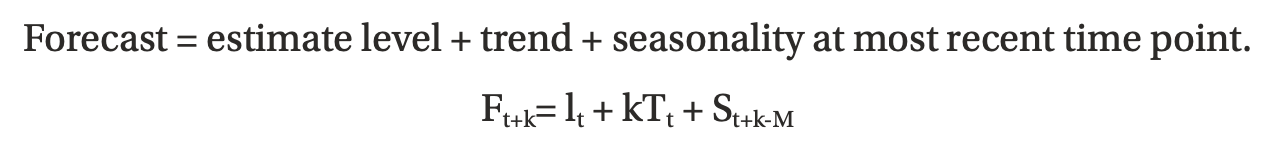
2. <b>multiplicative seasonality</b> model with the <b>additive trend</b> :

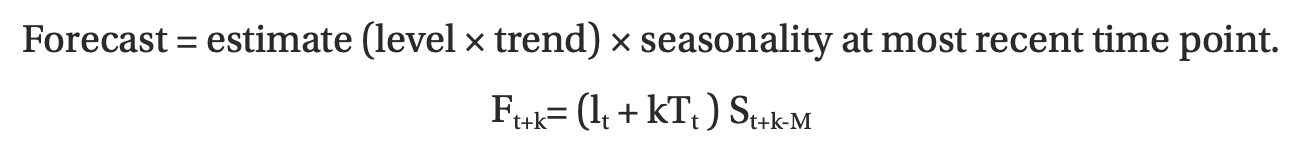

#### Holt-Winter exponential smoothing에서 3가지 smoothing constants는 Level, Trend, Seasonality
- Total components : level, trend, seasonality, noise (with M seasons)

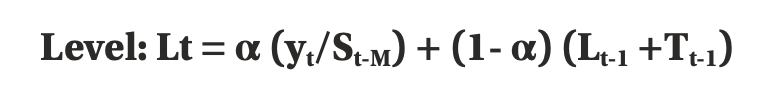
- ($y_t$/$S_{t-M}$) : deseasonalizing value of y
- updating the previous level by ($L_{t-1}$ + $T_{t-1}$)

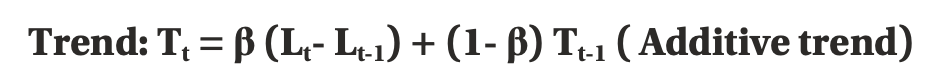
- update the previous trend $T_{t-1}$ by considering the latest difference between levels ($L_t$ - $L_{t-1}$)

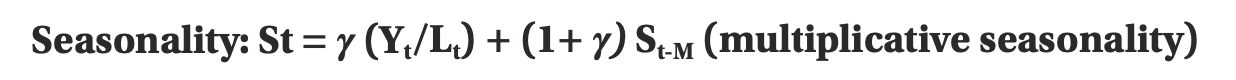
- detrended value of Y : ($Y_t$/$L_t$)
- the most recent seasonal component $S_{t-M}$

In [1]:
from statsmodels.tsa.api import ExponentialSmoothing
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [2]:
# FaceBook stock data from 2014 to 2019
df = pd.read_csv("./Data/FB.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
1,2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2,2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
3,2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
4,2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600
...,...,...,...,...,...,...,...
1254,2019-12-02,202.130005,202.179993,198.050003,199.699997,199.699997,11503400
1255,2019-12-03,197.600006,198.929993,195.080002,198.820007,198.820007,11595300
1256,2019-12-04,200.000000,200.029999,198.050003,198.710007,198.710007,8456300
1257,2019-12-05,199.860001,201.289993,198.210007,199.360001,199.360001,9740400


In [3]:
X = df['Close']          # 종가 데이터만 사용
train = X.iloc[:-30]     # 마지막 30일 데이터 제외한 train 데이터
test = X.iloc[-30:]      # 마지막 30일 데이터를 할당한 test 데이터

- Holt-Winter's exponential smoothing parameters:
    - <b>endog(array-like)</b> : Time series
    - <b>trend({"add", "mul", "additive", "multiplicative", None}, optional)</b> : Type of trend component
    - <b>damped(bool, optional)</b> : Whether the trend component should be damped
    - <b>seasonal({"add", "mul", "additive", "multiplicative", None}, optional)</b> : Type of seasonal component
    - <b>seasonal_periods(int, optional)</b> : The number of seasons to consider for Holt-Winters
    
- fit parameters:
    - <b>smoothing_level(float, optional)</b> : <b>alpha value</b> of the simple exponential smoothing
    - <b>smoothing_slope(float, optional)</b> : <b>beta value</b> of the Holt trend method
    - <b>smoothing_seasonal(float, optional)</b> : <b>gamma value</b> of the Holt-Winter seasonal method
    - <b>damping_slope(float, optional)</b> : <b>phi value</b> of the damped method
    - <b>optimized(bool, optional)</b> : whether the values that have not been set earlier should be <b>optimized automatically</b><em>(이전에 설정하지 않은 값들을 자동 최적화할건지)</em>
    - <b>use_boxcox({True, False, 'log', float}, optional)</b> : whether <b>the box cox transform</b> should be applied to the data first. If log, then it applies the log. If float, then it uses a lambda equal to float.
    - <b>remove_bias(bool, optional)</b> : whether <b>the bias should be removed</b> from the forecast values and fitted values before being returned. It does this by enforcing average residuals equal to zero.<em>(평균 잔차를 0으로 적용하여, 예측값과 피팅된 값이 반환되기 전에 bias 제거할지)</em>
    - <b>use_basinhopping(bool, optional)</b> : whether the optimizer should try harder using basinhopping to find optimal values

In [4]:
def timeseries_evaluation_metrics_func(y_true, y_pred):         # all the required evaluation metrics
    def mean_absolute_percentage_error(y_true, y_pred):         # MAPE metric
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("Evaluation metric results: ")
    print(f"MSE is : {metrics.mean_squared_error(y_true, y_pred)}")
    print(f"MAE is : {metrics.mean_absolute_error(y_true, y_pred)}")
    print(f"RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}")
    print(f"MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}")
    print(f"R2 is : {metrics.r2_score(y_true, y_pred)}", end = '\n\n')

### Custom Grid Search

In [5]:
param_grid = {'trend': ['add', 'mul'],
              'seasonal': ['add', 'mul'],
              'seasonal_periods': [3, 6, 12],
              'smoothing_level': [.10, .20, .30, .40, .50, .60, .70, .80, .90],
              'smoothing_slope': [.10, .20, .30, .40, .50, .60, .70, .80, .90],
              'damping_slope' : [.10, .20, .30, .40, .50, .60, .70, .80, .90],
              'damped': [True, False],
              'use_boxcox': [True, False],
              'remove_bias': [True, False],
              'use_basinhopping': [True, False]}  # 10개
pg = list(ParameterGrid(param_grid))              # 가능한 조합 수 계산
len(pg)

139968

In [6]:
import warnings
warnings.filterwarnings(action = 'ignore')

df_results_moni = pd.DataFrame(columns = ['trend', 'seasonal', 'seasonal_periods', 'smoothing_level', 'smoothing_slope', 'damping_slope', 'damped', 'use_boxcox', 'remove_bias', 'use_basinhopping', 'RMSE', 'r2'])
start = timer()
print('Starting Grid Search...')
for a, b in enumerate(pg):
    print('Current: {} | Total : {}'.format(a+1, len(pg)), end='\r')
    trend = b.get('trend')
    seasonal = b.get('seasonal')
    seasonal_periods = b.get('seasonal_periods')
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    use_boxcox = b.get('use_boxcox')
    remove_bias = b.get('remove_bias')
    use_basinhopping = b.get('use_basinhopping')
    # print(trend, seasonal, seasonal_periods, smoothing_level, smoothing_slope, damping_slope, damped, use_boxcox, remove_bias, use_basinhopping)
    fit1 = ExponentialSmoothing(train,
                                trend = trend,
                                damped = damped,
                                seasonal_periods = seasonal_periods).fit(smoothing_level = smoothing_level,
                                                                         smoothing_slope = smoothing_slope,
                                                                         damping_slope = damping_slope,
                                                                         use_boxcox = use_boxcox,
                                                                         optimized = False)
    # fit1.summary()
    z = fit1.forecast(30)
    # print(z)
    df_pred = pd.DataFrame(z, columns = ['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    df_results_moni = df_results_moni.append({'trend': trend,
                                              'seasonal': seasonal,
                                              'seasonal_periods': seasonal_periods,
                                              'smoothing_level': smoothing_level,
                                              'smoothing_slope': smoothing_slope,
                                              'damping_slope': damping_slope,
                                              'damped': damped,
                                              'use_boxcox': use_boxcox,
                                              'remove_bias': remove_bias,
                                              'use_basinhopping': use_basinhopping,
                                              'RMSE': RMSE,
                                              'r2': r2},
                                              ignore_index = True)
print("End of Grid Search")
end = timer()
print(f"Total time taken to complete grid search in seconds: {(end - start)}")

Starting Grid Search...
End of Grid SearchTotal : 139968
Total time taken to complete grid search in seconds: 5648.812739


###### seasonal 변수를 Grid Search parameter로 구했으나 모델에 실제로 사용되진 않았음(하단의 fit1.summary() 참고)

In [7]:
print(f"Below mentioned parameter gives least RMSE and r2")
df_results_moni.sort_values(by = ['RMSE', 'r2']).head(1)

Below mentioned parameter gives least RMSE and r2


,trend,seasonal,seasonal_periods,smoothing_level,smoothing_slope,damping_slope,damped,use_boxcox,remove_bias,use_basinhopping,RMSE,r2
70605,mul,add,3,0.9,0.6,0.1,False,False,True,True,2.162275,0.744551


In [8]:
df_results_moni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139968 entries, 0 to 139967
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   trend             139968 non-null  object 
 1   seasonal          139968 non-null  object 
 2   seasonal_periods  139968 non-null  object 
 3   smoothing_level   139968 non-null  float64
 4   smoothing_slope   139968 non-null  float64
 5   damping_slope     139968 non-null  float64
 6   damped            139968 non-null  object 
 7   use_boxcox        139968 non-null  object 
 8   remove_bias       139968 non-null  object 
 9   use_basinhopping  139968 non-null  object 
 10  RMSE              139968 non-null  float64
 11  r2                139968 non-null  float64
dtypes: float64(5), object(7)
memory usage: 12.8+ MB


In [18]:
fit1 = ExponentialSmoothing(train,
                            trend = 'mul',
                            damped = False,
                            seasonal_periods = 3).fit(smoothing_level = 0.9,
                                                      smoothing_slope = 0.6,
                                                      damping_slope = 0.1,
                                                      use_boxcox = False,
                                                      use_basinhopping = True,
                                                      optimized = False)
Forecast_custom_pred = fit1.forecast(30)
fit1.summary()

Dep. Variable:,Close,No. Observations:,1229
Model:,ExponentialSmoothing,SSE,12070.220
Optimized:,False,AIC,2815.700
Trend:,Multiplicative,BIC,2836.156
Seasonal:,None,AICC,2815.769
Seasonal Periods:,None,Date:,"Sat, 02 Oct 2021"
Box-Cox:,False,Time:,15:58:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
smoothing_trend,0.6000000,beta,False


In [11]:
timeseries_evaluation_metrics_func(test, Forecast_custom_pred)

Evaluation metric results: 
MSE is : 4.675431534981652
MAE is : 1.7892531792844002
RMSE is : 2.1622746206209915
MAPE is : 0.9154984217657036
R2 is : 0.7445509080821948



### Automated Grid Search
- <b>(optimized = True)</b> : log likelihood 최대화하는 model parameter 자동 최적화
- <b>(use_brute = True)</b> : brute-force (grid) optimizer를 사용해 좋은 starting values 적용

In [12]:
# Fitting model with (optimized = True)
fitESAUTO = ExponentialSmoothing(train).fit(optimized = True, use_brute = True)
fitESAUTO.summary()

Dep. Variable:,Close,No. Observations:,1229
Model:,ExponentialSmoothing,SSE,8965.774
Optimized:,True,AIC,2446.285
Trend:,None,BIC,2456.513
Seasonal:,None,AICC,2446.318
Seasonal Periods:,None,Date:,"Sat, 02 Oct 2021"
Box-Cox:,False,Time:,13:49:21
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9808445,alpha,True
initial_level,76.525895,l.0,True


In [13]:
fitESAUTOpred = fitESAUTO.forecast(30)

In [14]:
timeseries_evaluation_metrics_func(test,fitESAUTOpred)

Evaluation metric results: 
MSE is : 97.68044573557596
MAE is : 8.909413783986475
RMSE is : 9.883341830351512
MAPE is : 4.5162808209859
R2 is : -4.336915100688613



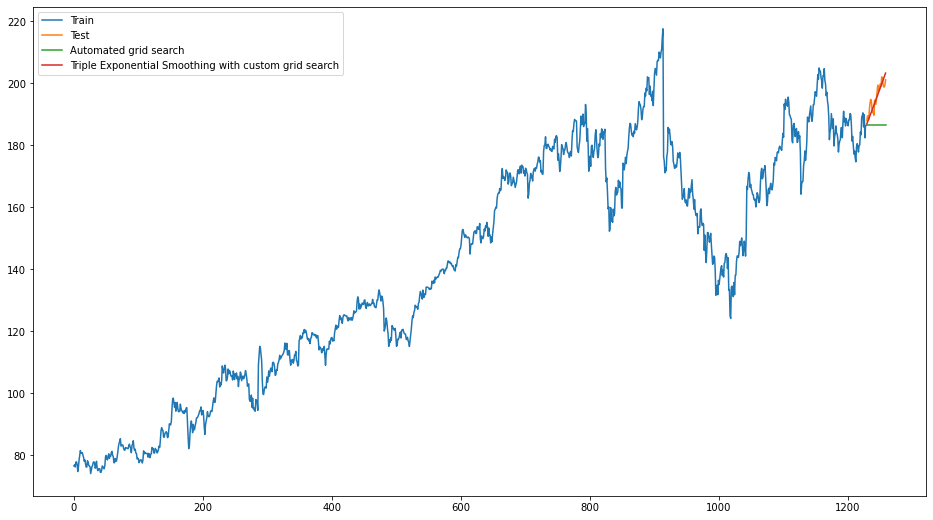

In [15]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train, label = "Train")
plt.plot(test, label = "Test")
plt.plot(fitESAUTOpred, label = "Automated grid search")
plt.plot(Forecast_custom_pred, label = "Triple Exponential Smoothing with custom grid search")
plt.legend(loc = 'best')
plt.show()

### Conclusion from Evaluation metrics & Graph
- triple exponential smoothing(Holt-Winter) <b>outperforms</b> double exponential smoothing
- trend & seasonality 유무에 따른 모델 사용
    - trend(x) & seasonality(x) : Use simple exponential smoothing
    - trend(o) & seasonality(x) : Use double exponential smoothing
    - trend(o) & seasonality(o) : Use triple exponential smoothing